# Physically labeled data: pyfocs single-ended examples

Finally, after all of that (probably confusing) work we can map the data to physical coordinates.

In [1]:
import xarray as xr
import pyfocs
import os

/Users/karllapo/anaconda3/lib/python3.7/typing.py:847: FutureWarning: xarray subclass DataStore should explicitly define __slots__
  super().__init_subclass__(*args, **kwargs)


# 1. Load data

## 1.1 Configuration files

As in the previous example we will load and prepare the configuration files. This time we will load all the configuration files.

Physically labeled data is triggered by setting the below flag within the configuration file.

```python
final_flag = True
```

In [2]:
dir_example = os.path.join('../tests/data/')

# Grab a configuration file for the twisted pair pvc fiber and for the stainless steel fiber
config_names = [
    'example_configuration_steelfiber.yml',
    'example_twistedpair_bothwls.yml',
    'example_twistedpair_p1wls.yml',
    'example_twistedpair_p2wls.yml',
]

cfg_fname = os.path.join(dir_example, config_names[0])
cfg_ss, lib_ss = pyfocs.check.config(cfg_fname, ignore_flags=True)

cfg_fname = os.path.join(dir_example, config_names[1])
cfg_both, lib_both = pyfocs.check.config(cfg_fname, ignore_flags=True)

cfg_fname = os.path.join(dir_example, config_names[2])
cfg_p1, lib_p1 = pyfocs.check.config(cfg_fname, ignore_flags=True)

cfg_fname = os.path.join(dir_example, config_names[3])
cfg_p2, lib_p2 = pyfocs.check.config(cfg_fname, ignore_flags=True)


## 1.2 Data

- In this case we only use a single twisted pair, p1, since it is closer to the DTS device in LAF space yielding a less noisy signal.
- Additionally, we will load the paired heated-unheated stainless steel fiber that has been interpolated to a common spatial index.


In [3]:
ds_p1 = xr.open_dataset(os.path.join(dir_example, 'multifiledemo', 'final', 'multifiledemo_final_20190722-0000_p1-wls_unheated.nc'))
ds_p2 = xr.open_dataset(os.path.join(dir_example, 'multifiledemo', 'final', 'multifiledemo_final_20190722-0000_p2-wls_unheated.nc'))
ds_cold = xr.open_dataset(os.path.join(dir_example, 'multifiledemo', 'final', 'multifiledemo_final_20190722-0000_ss-wls_unheated.nc'))
ds_heat = xr.open_dataset(os.path.join(dir_example, 'multifiledemo', 'final', 'multifiledemo_final_20190722-0000_ss-wls_heated.nc'))

print('=================')
print('Unheated fibers - Twisted PVC fiber, pair 1')
print(ds_p1)
print('')

print('=================')
print('Unheated fibers - Twisted PVC fiber, pair 2')
print(ds_p2)
print('')

print('=================')
print('Unheated fibers - stainless steel')
print(ds_cold)
print('')

print('=================')
print('Heated fibers - stainless steel')
print(ds_heat)
print('')


Unheated fibers - Twisted PVC fiber, pair 1
<xarray.Dataset>
Dimensions:   (time: 60, xyz: 1612)
Coordinates:
  * time      (time) datetime64[ns] 2019-07-22T00:00:05 ... 2019-07-22T00:05:00
    LAF       (xyz) float64 ...
    unheated  (xyz) object ...
    x         (xyz) float64 ...
    y         (xyz) float64 ...
    z         (xyz) float64 ...
Dimensions without coordinates: xyz
Data variables:
    cal_temp  (time, xyz) float64 ...
Attributes:
    dt:        5s
    dLAF:      0.254
    unheated:  IR_NE1_p1;IR_NE1_p2;IR_NE2_p1;IR_NE2_p2;IR_NW_p1;IR_NW_p2;IR_S...

Unheated fibers - Twisted PVC fiber, pair 2
<xarray.Dataset>
Dimensions:   (time: 60, xyz: 1612)
Coordinates:
  * time      (time) datetime64[ns] 2019-07-22T00:00:05 ... 2019-07-22T00:05:00
    LAF       (xyz) float64 ...
    unheated  (xyz) object ...
    x         (xyz) float64 ...
    y         (xyz) float64 ...
    z         (xyz) float64 ...
Dimensions without coordinates: xyz
Data variables:
    cal_temp  (time, xyz) f

Here we see that all datasets now have `x`, `y`, and `z` coordinates which are labeled using the `xyz` multiindex. Other quantities have been dropped.

The netcdf files are also now labeled differently. Channel information has been excluded and there is now a label on the location type at the end of the file name.

# 2. Calculate wind speed

## 2.1 Construct the power variable

Here I will construct a data variable of power. The details on what is happening here are not important besides `power` is a data variable with dimensions of LAF. The wind speed code can accept `power` as a DataArray with dimensions shared with `cal_temp` or as a single float.

In [4]:
import numpy as np


power_loc = {
    '1': [1892.5, 2063.5],
    '2': [2063.5, 2205.5],
    '3': [2207.0, 2361.],
    '4': [2361., 2524.]}

power_vals = {
    '1': 6.1,
    '2': 6.4,
    '3': 4.7,
    '4': 5.4,}

ds_heat['power'] = ('LAF', np.zeros_like(ds_heat.LAF))

for p in power_vals:
    laf_mask = ((ds_heat.LAF > power_loc[p][0]) & (ds_heat.LAF < power_loc[p][1]))
    ds_heat['power'] = xr.where(laf_mask, np.ones_like(ds_heat.LAF.values) * power_vals[p], ds_heat.power.values)

## 2.2 Calculate wind speed

In [5]:
wind_speed = pyfocs.wind_speed.calculate(ds_heat.cal_temp, ds_cold.cal_temp, ds_heat.power)


Converted air temperature from Celsius to Kelvin.
Converted air temperature from Celsius to Kelvin.
Converted air temperature from Celsius to Kelvin.
Converted air temperature from Celsius to Kelvin.


## 2.3 Split up wind speed based

Wind speed is most efficiently measured in the direction orthogonal to the fiber. Since we have fibers that are orthogonal to each other that means we effectively measured wind in two different directions. We represent that here by combining sections that are parallel to each other.

In [6]:
cross_valley_components = ['OR_SE', 'OR_NW']
logic = [wind_speed.unheated == l for l in cross_valley_components]
logic = xr.concat(logic, dim='locations').any(dim='locations')
wind_speed_cross_valley = wind_speed.where(logic, drop=True)

along_valley_components = ['OR_SW2', 'OR_SW1', 'OR_NE1', 'OR_NE2']
logic = [wind_speed.unheated == l for l in along_valley_components]
logic = xr.concat(logic, dim='locations').any(dim='locations')
wind_speed_along_valley = wind_speed.where(logic, drop=True)

## 2.4 Create a Dataset that contains all unheated data

In [7]:
unheated = xr.concat([ds_cold, ds_p1], dim='xyz', coords='different')

# 3. Plot your Fiber Optic Distributed Sensing data

## 3.1 Wind speed and temperature

Text(0, 0.5, 'Cross valley wind (m/s)')

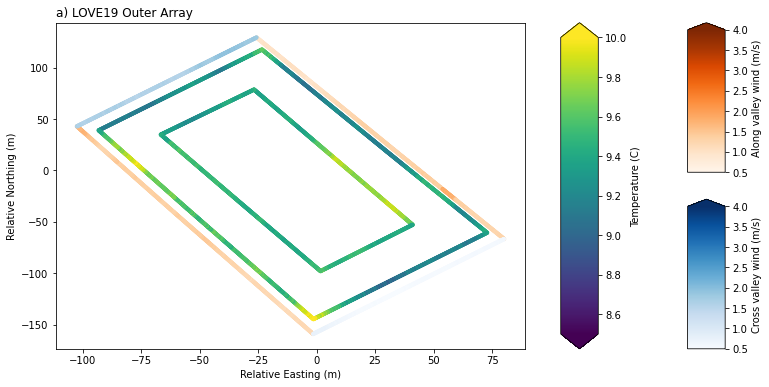

In [8]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(12, 6),)

spec = fig.add_gridspec(ncols=4,
                        nrows=2,
                        width_ratios=[1, 0.08, 0.04, 0.08],
                        hspace=0.18, wspace=0.25,
                        )
ax_ew_cbar = fig.add_subplot(spec[0, 3])
ax_ns_cbar = fig.add_subplot(spec[1, 3])
ax_t_cbar = fig.add_subplot(spec[:, 1])
ax_temp = fig.add_subplot(spec[:, 0])

im = ax_temp.scatter(unheated.x, unheated.y, s=10,
                c=unheated.mean(dim='time').cal_temp.values,
                cmap='viridis', vmin=8.5, vmax=10)
ax_temp.set_ylabel('Relative Northing (m)')
ax_temp.set_xlabel('Relative Easting (m)')
plt.colorbar(im, cax=ax_t_cbar, extend='both')
ax_t_cbar.set_ylabel('Temperature (C)')
ax_temp.set_title('a) LOVE19 Outer Array', loc='left')

im = ax_temp.scatter(wind_speed_along_valley.x * 1.1,
                     wind_speed_along_valley.y * 1.1,
                     s=10,
                     c=wind_speed_along_valley.mean(dim='time').values,
                     cmap='Oranges', vmin=0.5, vmax=4)
plt.colorbar(im, cax=ax_ew_cbar, extend='max')
ax_ew_cbar.set_ylabel('Along valley wind (m/s)')

im = ax_temp.scatter(wind_speed_cross_valley.x * 1.1,
                     wind_speed_cross_valley.y * 1.1,
                     s=10,
                     c=wind_speed_cross_valley.mean(dim='time').values,
                     cmap='Blues', vmin=0.5, vmax=4)
plt.colorbar(im, cax=ax_ns_cbar, extend='max')
ax_ns_cbar.set_ylabel('Cross valley wind (m/s)')

## 3.2 Biases in space

Text(0.0, 1.0, 'LOVE19 Twisted PVC Fiber Bias')

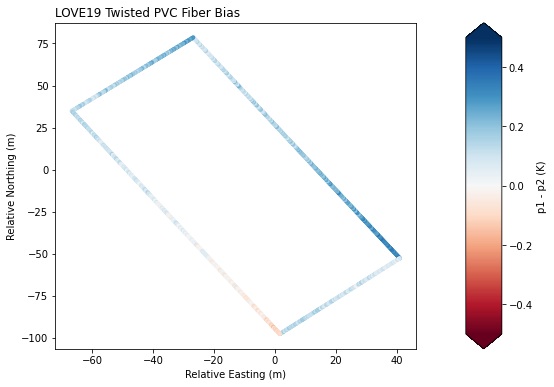

In [9]:
ds_p2 = ds_p2.interp_like(ds_p1)

fig = plt.figure(figsize=(8, 6),)

spec = fig.add_gridspec(ncols=2,
                        nrows=1,
                        width_ratios=[1, 0.1],
                        hspace=0.18, wspace=0.25,
                        )
ax_t_cbar = fig.add_subplot(spec[:, 1])
ax_temp = fig.add_subplot(spec[:, 0])

im = ax_temp.scatter(
    ds_p1.x,
    ds_p1.y,
    s=10,
    c=(ds_p1.cal_temp - ds_p2.cal_temp).mean(dim='time').values,
    cmap='RdBu', vmin=-0.5, vmax=0.5)
ax_temp.set_ylabel('Relative Northing (m)')
ax_temp.set_xlabel('Relative Easting (m)')
plt.colorbar(im, cax=ax_t_cbar, extend='both')
ax_t_cbar.set_ylabel('p1 - p2 (K)')
ax_temp.set_title('LOVE19 Twisted PVC Fiber Bias', loc='left')

Here we can see that the reference sections are a bit misleading. While they evaluate to effectively zero bias, there are substantial biases between what should be replicate measurements. We have found this to be typical of DTS observations. The cause and correction is a subject of on-going research but we highlight as a final word of caution on DTS. The method is excpetionally powerful but is very far from a push-button operation. It requires a substantial investment in time for all steps: setting up the fiber takes much longer than other instruments, preparing the dataset is a long process even with the tools provided by pyfocs, and it is still a new technique that is subject to uncertainties that are not even known to the community.